In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataUtils import DataUtils as utils
from model_utils import ModelUtils as mutls

C:\Users\Yang\.conda\envs\test_speedcom\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
from keras import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Conv1D, Activation

Using TensorFlow backend.


In [3]:
dset = utils.readData('temp_cleaned_data.tsv')

   #      Name      name_smiles  Wavelength  Epsilon  Quantum Yield
0  1   Benzene      C1=CC=CC=C1      254.75      210          0.053
1  2   Toluene     CC1=CC=CC=C1      261.75     2860          0.170
2  3  o-Xylene    CC1=CC=CC=C1C      263.00      254          0.170
3  4  m-Xylene  CC1=CC(=CC=C1)C      265.00      284          0.130
4  5  p-Xylene  CC1=CC=C(C=C1)C      275.00      770          0.220


In [4]:
X, Y = utils.get_xy(dset, 2, 3)

(array([91., 57., 18., 25., 21., 23., 18.,  7.,  3.,  4.]),
 array([203. , 264.5, 326. , 387.5, 449. , 510.5, 572. , 633.5, 695. ,
        756.5, 818. ]),
 <a list of 10 Patch objects>)

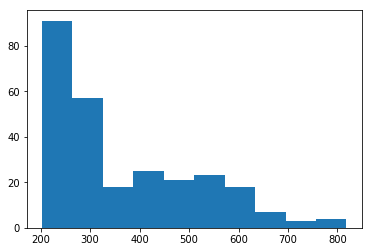

In [5]:
plt.hist(list(dset[:,3]))

In [6]:
Y_category = (Y - 200) // 20

(array([81., 65., 18., 25., 18., 25., 18.,  9.,  4.,  4.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

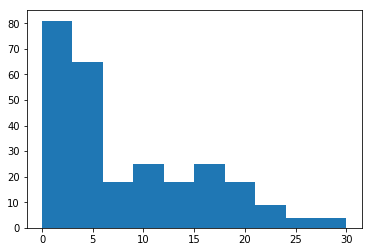

In [7]:
plt.hist(list(Y_category))

In [8]:
d_cat=mutls.combine_columns((X,Y_category))

In [9]:
cls, counts = np.unique(Y_category, return_counts=True)
cls_counts = dict(zip(cls, counts))
print(cls_counts)

{0.0: 18, 1.0: 23, 2.0: 40, 3.0: 44, 4.0: 14, 5.0: 7, 6.0: 8, 7.0: 4, 8.0: 6, 9.0: 3, 10.0: 12, 11.0: 10, 12.0: 7, 13.0: 4, 14.0: 7, 15.0: 10, 16.0: 5, 17.0: 10, 18.0: 6, 19.0: 6, 20.0: 6, 21.0: 3, 22.0: 4, 23.0: 2, 24.0: 2, 25.0: 2, 28.0: 1, 29.0: 2, 30.0: 1}


#### subsample the data in each class to undersample some class with big counts

In [10]:
subsampled=mutls.subsampling(d_cat,1,10,cls_counts)

In [11]:
for row in d_cat:
    print(row[0])
    print(row[1])
    cls = row[1]
    print(np.random.randint(0, cls_counts[cls]))
    break

C1=CC=CC=C1
2.0
1


(array([ 8., 12., 15., 11., 12.,  7.,  8.,  4.,  6.,  3., 11., 10.,  7.,
         4.,  7., 10.,  5., 10.,  6.,  6.,  6.,  3.,  4.,  2.,  2.,  2.,
         0.,  0.,  1.,  2.,  1.]),
 array([ 0.        ,  0.96774194,  1.93548387,  2.90322581,  3.87096774,
         4.83870968,  5.80645161,  6.77419355,  7.74193548,  8.70967742,
         9.67741935, 10.64516129, 11.61290323, 12.58064516, 13.5483871 ,
        14.51612903, 15.48387097, 16.4516129 , 17.41935484, 18.38709677,
        19.35483871, 20.32258065, 21.29032258, 22.25806452, 23.22580645,
        24.19354839, 25.16129032, 26.12903226, 27.09677419, 28.06451613,
        29.03225806, 30.        ]),
 <a list of 31 Patch objects>)

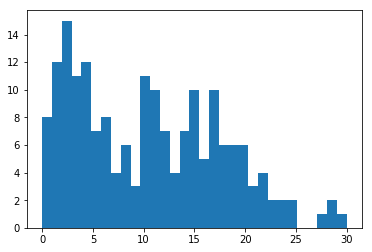

In [12]:
plt.hist(list(subsampled[:, 1]), bins=31)

In [13]:
X, y = subsampled[:,0], subsampled[:,1]
word_map = utils.get_wordmap(X)
embed_length = utils.get_max_len(X) + 2
X_numeric = utils.numeric_encoding(x_list=X, uniform_length=embed_length, word_map=word_map)
y_onehot = mutls.onehot_encode_y(y=y, num_class=31)
X_train, X_test, y_train, y_test = utils.splitData(X_numeric, y_onehot, ratio=0.10)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(166, 276)
(19, 276)
(166, 31)
(19, 31)


#### model1: embedding layer with category data and rmsprop optimizer (slow and bad)

In [14]:
embedding_dim = 50
num_filter = 192
kernel_size = 10
rnn1_size = 224
rnn2_size = 384
dropout_rate = 0.4


loss = 'categorical_crossentropy'
metrics = ['accuracy']
num_classes = 31

model = Sequential()
model.add(Embedding(len(word_map), embedding_dim, input_length=embed_length))
model.add(Conv1D(num_filter, kernel_size, activation='relu'))
model.add(LSTM(rnn1_size, return_sequences=True, dropout=dropout_rate))
model.add(LSTM(rnn2_size))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='rmsprop', loss=loss, metrics=metrics)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
batch_size = 32
epochs = 50

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=[X_test, y_test])

Instructions for updating:
Use tf.cast instead.
Train on 166 samples, validate on 19 samples
Epoch 1/50
166/166 [==============================] - 36s 214ms/step - loss: 3.4277 - acc: 0.0361 - val_loss: 3.4629 - val_acc: 0.2105
Epoch 2/50
166/166 [==============================] - 29s 175ms/step - loss: 3.4843 - acc: 0.0361 - val_loss: 3.2147 - val_acc: 0.0526
Epoch 3/50
166/166 [==============================] - 30s 180ms/step - loss: 3.3111 - acc: 0.0542 - val_loss: 3.1872 - val_acc: 0.2105
Epoch 4/50
166/166 [==============================] - 29s 178ms/step - loss: 3.2832 - acc: 0.0542 - val_loss: 3.1552 - val_acc: 0.2105
Epoch 5/50
166/166 [==============================] - 29s 177ms/step - loss: 3.2932 - acc: 0.0301 - val_loss: 3.2062 - val_acc: 0.0526
Epoch 6/50
166/166 [==============================] - 30s 178ms/step - loss: 3.2602 - acc: 0.0482 - val_loss: 3.2369 - val_acc: 0.0526
Epoch 7/50
166/166 [==============================] - 30s 179ms/step - loss: 3.2523 - acc: 0.0482

#### model2 no imbedding, adam optimizer

In [16]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

rnn1_size = 224
rnn2_size = 384
dropout_rate = 0.4
loss = 'categorical_crossentropy'
metrics = ['accuracy']
num_classes = 31
optimizer = 'adam' #use adam optimizer

model_1 = Sequential()
model_1.add(LSTM(rnn1_size, return_sequences=True, input_shape=(276,1))) #276
model_1.add(LSTM(rnn2_size))
model_1.add(Dense(num_classes, activation='softmax'))
model_1.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
batch_size = 32
epochs = 50

model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=[X_test, y_test])

Train on 166 samples, validate on 19 samples
Epoch 1/50
166/166 [==============================] - 18s 111ms/step - loss: 3.4318 - acc: 0.0301 - val_loss: 3.2489 - val_acc: 0.0526
Epoch 2/50
166/166 [==============================] - 16s 96ms/step - loss: 3.2947 - acc: 0.0482 - val_loss: 3.2740 - val_acc: 0.0000e+00
Epoch 3/50
166/166 [==============================] - 16s 99ms/step - loss: 3.2554 - acc: 0.0663 - val_loss: 3.2637 - val_acc: 0.0526
Epoch 4/50
166/166 [==============================] - 17s 101ms/step - loss: 3.2651 - acc: 0.0663 - val_loss: 3.2877 - val_acc: 0.0000e+00
Epoch 5/50
166/166 [==============================] - 17s 104ms/step - loss: 3.2373 - acc: 0.0663 - val_loss: 3.3340 - val_acc: 0.0000e+00
Epoch 6/50
166/166 [==============================] - 17s 104ms/step - loss: 3.2375 - acc: 0.0482 - val_loss: 3.3037 - val_acc: 0.0000e+00
Epoch 7/50
166/166 [==============================] - 17s 100ms/step - loss: 3.2291 - acc: 0.0663 - val_loss: 3.2345 - val_acc: 0.0

In [33]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 276, 224)          202496    
_________________________________________________________________
lstm_10 (LSTM)               (None, 384)               935424    
_________________________________________________________________
dense_5 (Dense)              (None, 31)                11935     
Total params: 1,149,855
Trainable params: 1,149,855
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_1.fit(X_train, y_train, batch_size=batch_size, epochs=100, validation_data=[X_test, y_test])

Train on 166 samples, validate on 19 samples
Epoch 1/100
166/166 [==============================] - 15s 92ms/step - loss: 3.2025 - acc: 0.0663 - val_loss: 3.2026 - val_acc: 0.0000e+00
Epoch 2/100
166/166 [==============================] - 16s 96ms/step - loss: 3.2051 - acc: 0.0602 - val_loss: 3.2025 - val_acc: 0.2105
Epoch 3/100
166/166 [==============================] - 15s 93ms/step - loss: 3.2032 - acc: 0.0663 - val_loss: 3.2192 - val_acc: 0.2105
Epoch 4/100
166/166 [==============================] - 16s 93ms/step - loss: 3.2092 - acc: 0.0783 - val_loss: 3.2435 - val_acc: 0.0000e+00
Epoch 5/100
166/166 [==============================] - 15s 93ms/step - loss: 3.2092 - acc: 0.0663 - val_loss: 3.2617 - val_acc: 0.0000e+00
Epoch 6/100
166/166 [==============================] - 15s 92ms/step - loss: 3.2055 - acc: 0.0783 - val_loss: 3.2557 - val_acc: 0.0000e+00
Epoch 7/100
166/166 [==============================] - 15s 93ms/step - loss: 3.2037 - acc: 0.0663 - val_loss: 3.2394 - val_acc: 0

KeyboardInterrupt: 